In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import TOPO
import importlib
import pandas as pd
from time import time
import os

### Computing the keypoints with the KAZE algorithm for each tile

In [ ]:
importlib.reload(TOPO)
topoDir = 'TOPO Datas/Tiles_From_LIDAR_30cm_archive/'
tileNames = [['Elevation_030_ALS_line101.0.tif', 'Intensity_030_ALS_line101.0.tif'],
             ['Elevation_030_ALS_line102.0.tif', 'Intensity_030_ALS_line102.0.tif'],
             ['Elevation_030_ALS_line103.0.tif', 'Intensity_030_ALS_line103.0.tif'],
             ['Elevation_030_ALS_line104.0.tif', 'Intensity_030_ALS_line104.0.tif']]

firstFile = True
indexTotal = 0 

imageList, kpsList, dscsList = [], [], []

for tileName in tileNames:

    # 1° Load the image
    elevImage = cv2.imread(topoDir + tileName[0], cv2.IMREAD_UNCHANGED)
    intensImage = cv2.imread(topoDir + tileName[1], cv2.IMREAD_UNCHANGED)
    imageList.append(intensImage)
    
    # 2° Compute the average pixel value and replace the undefined values
    elevTotalVal = 0

    for row in elevImage:
        for pixel in row:
            if pixel != -9999.0:
                elevTotalVal += pixel

    elevMeanVal = elevTotalVal / (elevImage.shape[0] * elevImage.shape[1])
    elevImage[elevImage == -9999.0] = elevMeanVal
    
    intensTotalVal = 0

    for row in intensImage:
        for pixel in row:
            if pixel != -9999.0:
                intensTotalVal += pixel

    intensMeanVal = intensTotalVal / (intensImage.shape[0] * intensImage.shape[1])
    intensImage[intensImage == -9999.0] = intensMeanVal
    
    imageMeanVal = [elevMeanVal, intensMeanVal]
    
    # 3° Plot and save the image
    f, axes = plt.subplots(1,2,figsize=(15,15))
    axes[0].imshow(elevImage)
    axes[0].title.set_text('Elevation Image')
    axes[1].imshow(intensImage)
    axes[1].title.set_text('Intensity Image')
    
    # 4° Create new image by using the elevation and the intensity data as channels
    
    tileImage = np.zeros((intensImage.shape[0], intensImage.shape[1], 3))
    tileImage[:, :, 0] = elevImage
    tileImage[:, :, 1] = intensImage
    
    elevImage_RGB = cv2.cvtColor(np.float32(elevImage), cv2.COLOR_GRAY2RGB)
    intensImage_RGB = cv2.cvtColor(np.float32(intensImage), cv2.COLOR_GRAY2RGB)
    
    # 5° Compute Kaze descriptor and draw keypoints
    
    tileKazeKps, tileKazeDscs, indexTotal = TOPO.kaze_descriptor(np.float32(tileImage), np.float32(imageMeanVal), 
                                                                 tileName, firstFile, indexTotal)
    
    kpsList.append(tileKazeKps)
    dscsList.append(tileKazeDscs)
    
    if firstFile:
        firstFile = False
        
    elevKaze = TOPO.draw_keypoints(elevImage_RGB, tileKazeKps[-100:])
    intensKaze = TOPO.draw_keypoints(intensImage_RGB, tileKazeKps[-100:])
    
    # 6° Plot and save the image with the keypoints 
    
    f, axes = plt.subplots(1,2,figsize=(15,15))
    axes[0].imshow(elevKaze.astype(np.uint8))
    axes[0].title.set_text('Elevation Image Kaze')
    axes[1].imshow(intensKaze.astype(np.uint8))
    axes[1].title.set_text('Intensity Image Kaze')

### Overlap study

#### The translation parameters are given by:

- Tile 1 to tile 2: x2 = x1 + 4694 , y2 = y1 - 66
- Tile 1 to tile 3: x3 = x1 + 4517 , y3 = y1 + 233
- Tile 2 to tile 3: x3 = x2 - 177 , y3 = y2 + 299
- Tile 2 to tile 4: x4 = x2 - 2941 , y4 = y2 + 2540
- Tile 3 to tile 4: x4 = x3 - 2764 , y4 = y3 + 2241

In [ ]:
# Tile 2 Dictionary
kpsTile2 = []
for (kps, dsc) in zip(kpsList[1], dscsList[1]):
    kpsTile2.append({'x': kps.pt[0], 'y': kps.pt[1], 'dsc': dsc})
    
# Tile 3 Dictionary
kpsTile3 = []
for (kps, dsc) in zip(kpsList[2], dscsList[2]):
    kpsTile3.append({'x': kps.pt[0], 'y': kps.pt[1], 'dsc': dsc})
    
# Tile 4 Dictionary
kpsTile4 = []
for (kps, dsc) in zip(kpsList[3], dscsList[3]):
    kpsTile4.append({'x': kps.pt[0], 'y': kps.pt[1], 'dsc': dsc})
    
# Tile 1-2 Dictionary
kpsTile12 = []
for (kps, dsc) in zip(kpsList[0], dscsList[0]):
    kpsX_shifted = kps.pt[0] + 4694
    kpsY_shifted = kps.pt[1] - 66
    kpsTile12.append({'x': kpsX_shifted, 'y': kpsY_shifted, 'dsc': dsc})
    
# Tile 1-3 Dictionary
kpsTile13 = []
for (kps, dsc) in zip(kpsList[0], dscsList[0]):
    kpsX_shifted = kps.pt[0] + 4517
    kpsY_shifted = kps.pt[1] + 233
    kpsTile13.append({'x': kpsX_shifted, 'y': kpsY_shifted, 'dsc': dsc})
    
# Tile 2-3 Dictionary
kpsTile23 = []
for (kps, dsc) in zip(kpsList[1], dscsList[1]):
    kpsX_shifted = kps.pt[0] - 177
    kpsY_shifted = kps.pt[1] + 299
    kpsTile23.append({'x': kpsX_shifted, 'y': kpsY_shifted, 'dsc': dsc})
    
# Tile 2-4 Dictionary
kpsTile24 = []
for (kps, dsc) in zip(kpsList[1], dscsList[1]):
    kpsX_shifted = kps.pt[0] - 2941
    kpsY_shifted = kps.pt[1] + 2540
    kpsTile24.append({'x': kpsX_shifted, 'y': kpsY_shifted, 'dsc': dsc})
    
# Tile 3-4 Dictionary
kpsTile34 = []
for (kps, dsc) in zip(kpsList[2], dscsList[2]):
    kpsX_shifted = kps.pt[0] - 2764
    kpsY_shifted = kps.pt[1] + 2241
    kpsTile34.append({'x': kpsX_shifted, 'y': kpsY_shifted, 'dsc': dsc})

In [ ]:
maxX, minX, maxY, minY, midY, x1, x2, x3 = [], [], [], [], [], [], [], []

for indexTile, tile in enumerate(kpsList):
    tilePt = [kps.pt for kps in tile]
    tilePtX = [tilePt[kpsIndex][0] for kpsIndex in range(0, len(tilePt))]
    tilePtY = [tilePt[kpsIndex][1] for kpsIndex in range(0, len(tilePt))]
    maxX.append(np.max(tilePtX))
    minX.append(np.min(tilePtX))
    maxY.append(np.max(tilePtY))
    minY.append(np.min(tilePtY))
    
    midY.append((np.min(tilePtY) + np.max(tilePtY)) / 2)
    x1.append((np.max(tilePtX) + 3 * np.min(tilePtX)) / 4)
    x2.append((np.max(tilePtX) + np.min(tilePtX)) / 2)
    x3.append((3 * np.max(tilePtX) + np.min(tilePtX)) / 4)

#### Divide the keypoints in eight sectors, each one representing an octant of the tile

In [ ]:
# Tile 2 Division

tile2_octant1 = [kps for kps in kpsTile2 if kps['x'] > minX[1] and kps['x'] < x1[1] and kps['y'] > midY[1]]
tile2_octant2 = [kps for kps in kpsTile2 if kps['x'] > x1[1] and kps['x'] < x2[1] and kps['y'] > midY[1]]
tile2_octant3 = [kps for kps in kpsTile2 if kps['x'] > x2[1] and kps['x'] < x3[1] and kps['y'] > midY[1]]
tile2_octant4 = [kps for kps in kpsTile2 if kps['x'] > x3[1] and kps['x'] < maxX[1] and kps['y'] > midY[1]]
tile2_octant5 = [kps for kps in kpsTile2 if kps['x'] > minX[1] and kps['x'] < x1[1] and kps['y'] < midY[1]]
tile2_octant6 = [kps for kps in kpsTile2 if kps['x'] > x1[1] and kps['x'] < x2[1] and kps['y'] < midY[1]]
tile2_octant7 = [kps for kps in kpsTile2 if kps['x'] > x2[1] and kps['x'] < x3[1] and kps['y'] < midY[1]]
tile2_octant8 = [kps for kps in kpsTile2 if kps['x'] > x3[1] and kps['x'] < maxX[1] and kps['y'] < midY[1]]

lenTile2 = [len(tile2_octant1), len(tile2_octant2), len(tile2_octant3), len(tile2_octant4), len(tile2_octant5),
            len(tile2_octant6), len(tile2_octant7), len(tile2_octant8)]

# Tile 3 Division

tile3_octant1 = [kps for kps in kpsTile3 if kps['x'] > minX[2] and kps['x'] < x1[2] and kps['y'] > midY[2]]
tile3_octant2 = [kps for kps in kpsTile3 if kps['x'] > x1[2] and kps['x'] < x2[2] and kps['y'] > midY[2]]
tile3_octant3 = [kps for kps in kpsTile3 if kps['x'] > x2[2] and kps['x'] < x3[2] and kps['y'] > midY[2]]
tile3_octant4 = [kps for kps in kpsTile3 if kps['x'] > x3[2] and kps['x'] < maxX[2] and kps['y'] > midY[2]]
tile3_octant5 = [kps for kps in kpsTile3 if kps['x'] > minX[2] and kps['x'] < x1[2] and kps['y'] < midY[2]]
tile3_octant6 = [kps for kps in kpsTile3 if kps['x'] > x1[2] and kps['x'] < x2[2] and kps['y'] < midY[2]]
tile3_octant7 = [kps for kps in kpsTile3 if kps['x'] > x2[2] and kps['x'] < x3[2] and kps['y'] < midY[2]]
tile3_octant8 = [kps for kps in kpsTile3 if kps['x'] > x3[2] and kps['x'] < maxX[2] and kps['y'] < midY[2]]

lenTile3 = [len(tile3_octant1), len(tile3_octant2), len(tile3_octant3), len(tile3_octant4), len(tile3_octant5),
            len(tile3_octant6), len(tile3_octant7), len(tile3_octant8)]

tile3_octants = [tile3_octant1, tile3_octant2, tile3_octant3, tile3_octant4,
                 tile3_octant5, tile3_octant6, tile3_octant7, tile3_octant8]

# Tile 4 Division

tile4_octant1 = [kps for kps in kpsTile4 if kps['x'] > minX[3] and kps['x'] < x1[3] and kps['y'] > midY[3]]
tile4_octant2 = [kps for kps in kpsTile4 if kps['x'] > x1[3] and kps['x'] < x2[3] and kps['y'] > midY[3]]
tile4_octant3 = [kps for kps in kpsTile4 if kps['x'] > x2[3] and kps['x'] < x3[3] and kps['y'] > midY[3]]
tile4_octant4 = [kps for kps in kpsTile4 if kps['x'] > x3[3] and kps['x'] < maxX[3] and kps['y'] > midY[3]]
tile4_octant5 = [kps for kps in kpsTile4 if kps['x'] > minX[3] and kps['x'] < x1[3] and kps['y'] < midY[3]]
tile4_octant6 = [kps for kps in kpsTile4 if kps['x'] > x1[3] and kps['x'] < x2[3] and kps['y'] < midY[3]]
tile4_octant7 = [kps for kps in kpsTile4 if kps['x'] > x2[3] and kps['x'] < x3[3] and kps['y'] < midY[3]]
tile4_octant8 = [kps for kps in kpsTile4 if kps['x'] > x3[3] and kps['x'] < maxX[3] and kps['y'] < midY[3]]

lenTile4 = [len(tile4_octant1), len(tile4_octant2), len(tile4_octant3), len(tile4_octant4), len(tile4_octant5),
            len(tile4_octant6), len(tile4_octant7), len(tile4_octant8)]

# Tile 1-2 Division

tile12_octant1 = [kps for kps in kpsTile12 if kps['x'] > minX[1] and kps['x'] < x1[1] and kps['y'] > midY[1]]
tile12_octant2 = [kps for kps in kpsTile12 if kps['x'] > x1[1] and kps['x'] < x2[1] and kps['y'] > midY[1]]
tile12_octant3 = [kps for kps in kpsTile12 if kps['x'] > x2[1] and kps['x'] < x3[1] and kps['y'] > midY[1]]
tile12_octant4 = [kps for kps in kpsTile12 if kps['x'] > x3[1] and kps['x'] < maxX[1] and kps['y'] > midY[1]]
tile12_octant5 = [kps for kps in kpsTile12 if kps['x'] > minX[1] and kps['x'] < x1[1] and kps['y'] < midY[1]]
tile12_octant6 = [kps for kps in kpsTile12 if kps['x'] > x1[1] and kps['x'] < x2[1] and kps['y'] < midY[1]]
tile12_octant7 = [kps for kps in kpsTile12 if kps['x'] > x2[1] and kps['x'] < x3[1] and kps['y'] < midY[1]]
tile12_octant8 = [kps for kps in kpsTile12 if kps['x'] > x3[1] and kps['x'] < maxX[1] and kps['y'] < midY[1]]

lenTile12 = [len(tile12_octant1), len(tile12_octant2), len(tile12_octant3), len(tile12_octant4), len(tile12_octant5),
            len(tile12_octant6), len(tile12_octant7), len(tile12_octant8)]

# Tile 1-3 Division

tile13_octant1 = [kps for kps in kpsTile13 if kps['x'] > minX[2] and kps['x'] < x1[2] and kps['y'] > midY[2]]
tile13_octant2 = [kps for kps in kpsTile13 if kps['x'] > x1[2] and kps['x'] < x2[2] and kps['y'] > midY[2]]
tile13_octant3 = [kps for kps in kpsTile13 if kps['x'] > x2[2] and kps['x'] < x3[2] and kps['y'] > midY[2]]
tile13_octant4 = [kps for kps in kpsTile13 if kps['x'] > x3[2] and kps['x'] < maxX[2] and kps['y'] > midY[2]]
tile13_octant5 = [kps for kps in kpsTile13 if kps['x'] > minX[2] and kps['x'] < x1[2] and kps['y'] < midY[2]]
tile13_octant6 = [kps for kps in kpsTile13 if kps['x'] > x1[2] and kps['x'] < x2[2] and kps['y'] < midY[2]]
tile13_octant7 = [kps for kps in kpsTile13 if kps['x'] > x2[2] and kps['x'] < x3[2] and kps['y'] < midY[2]]
tile13_octant8 = [kps for kps in kpsTile13 if kps['x'] > x3[2] and kps['x'] < maxX[2] and kps['y'] < midY[2]]

lenTile13 = [len(tile13_octant1), len(tile13_octant2), len(tile13_octant3), len(tile13_octant4), len(tile13_octant5),
            len(tile13_octant6), len(tile13_octant7), len(tile13_octant8)]

tile13_octants = [tile13_octant1, tile13_octant2, tile13_octant3, tile13_octant4,
                 tile13_octant5, tile13_octant6, tile13_octant7, tile13_octant8]

# Tile 2-3 Division

tile23_octant1 = [kps for kps in kpsTile23 if kps['x'] > minX[2] and kps['x'] < x1[2] and kps['y'] > midY[2]]
tile23_octant2 = [kps for kps in kpsTile23 if kps['x'] > x1[2] and kps['x'] < x2[2] and kps['y'] > midY[2]]
tile23_octant3 = [kps for kps in kpsTile23 if kps['x'] > x2[2] and kps['x'] < x3[2] and kps['y'] > midY[2]]
tile23_octant4 = [kps for kps in kpsTile23 if kps['x'] > x3[2] and kps['x'] < maxX[2] and kps['y'] > midY[2]]
tile23_octant5 = [kps for kps in kpsTile23 if kps['x'] > minX[2] and kps['x'] < x1[2] and kps['y'] < midY[2]]
tile23_octant6 = [kps for kps in kpsTile23 if kps['x'] > x1[2] and kps['x'] < x2[2] and kps['y'] < midY[2]]
tile23_octant7 = [kps for kps in kpsTile23 if kps['x'] > x2[2] and kps['x'] < x3[2] and kps['y'] < midY[2]]
tile23_octant8 = [kps for kps in kpsTile23 if kps['x'] > x3[2] and kps['x'] < maxX[2] and kps['y'] < midY[2]]

lenTile23 = [len(tile23_octant1), len(tile23_octant2), len(tile23_octant3), len(tile23_octant4), len(tile23_octant5),
            len(tile23_octant6), len(tile23_octant7), len(tile23_octant8)]

# Tile 2-4 Division

tile24_octant1 = [kps for kps in kpsTile24 if kps['x'] >= minX[3] and kps['x'] <= x1[3] and kps['y'] >= midY[3]]
tile24_octant2 = [kps for kps in kpsTile24 if kps['x'] >= x1[3] and kps['x'] <= x2[3] and kps['y'] >= midY[3]]
tile24_octant3 = [kps for kps in kpsTile24 if kps['x'] >= x2[3] and kps['x'] <= x3[3] and kps['y'] >= midY[3]]
tile24_octant4 = [kps for kps in kpsTile24 if kps['x'] >= x3[3] and kps['x'] <= maxX[3] and kps['y'] >= midY[3]]
tile24_octant5 = [kps for kps in kpsTile24 if kps['x'] >= minX[3] and kps['x'] <= x1[3] and kps['y'] <= midY[3]]
tile24_octant6 = [kps for kps in kpsTile24 if kps['x'] >= x1[3] and kps['x'] <= x2[3] and kps['y'] <= midY[3]]
tile24_octant7 = [kps for kps in kpsTile24 if kps['x'] >= x2[3] and kps['x'] <= x3[3] and kps['y'] <= midY[3]]
tile24_octant8 = [kps for kps in kpsTile24 if kps['x'] >= x3[3] and kps['x'] <= maxX[3] and kps['y'] <= midY[3]]

lenTile24 = [len(tile24_octant1), len(tile24_octant2), len(tile24_octant3), len(tile24_octant4), len(tile24_octant5),
            len(tile24_octant6), len(tile24_octant7), len(tile24_octant8)]

# Tile 3-4 Division

tile34_octant1 = [kps for kps in kpsTile34 if kps['x'] >= minX[3] and kps['x'] <= x1[3] and kps['y'] >= midY[3]]
tile34_octant2 = [kps for kps in kpsTile34 if kps['x'] >= x1[3] and kps['x'] <= x2[3] and kps['y'] >= midY[3]]
tile34_octant3 = [kps for kps in kpsTile34 if kps['x'] >= x2[3] and kps['x'] <= x3[3] and kps['y'] >= midY[3]]
tile34_octant4 = [kps for kps in kpsTile34 if kps['x'] >= x3[3] and kps['x'] <= maxX[3] and kps['y'] >= midY[3]]
tile34_octant5 = [kps for kps in kpsTile34 if kps['x'] >= minX[3] and kps['x'] <= x1[3] and kps['y'] <= midY[3]]
tile34_octant6 = [kps for kps in kpsTile34 if kps['x'] >= x1[3] and kps['x'] <= x2[3] and kps['y'] <= midY[3]]
tile34_octant7 = [kps for kps in kpsTile34 if kps['x'] >= x2[3] and kps['x'] <= x3[3] and kps['y'] <= midY[3]]
tile34_octant8 = [kps for kps in kpsTile34 if kps['x'] >= x3[3] and kps['x'] <= maxX[3] and kps['y'] <= midY[3]]

lenTile34 = [len(tile34_octant1), len(tile34_octant2), len(tile34_octant3), len(tile34_octant4), len(tile34_octant5),
            len(tile34_octant6), len(tile34_octant7), len(tile34_octant8)]

#### Matches 1 - 2

In [ ]:
validMatches12 = []

for octant12, octant2 in zip(tile12_octants, tile2_octants):
    startTime = time()
    validMatches.extend([(kps_12, kps_2) for kps_12 in octant12 for kps_2 in octant2
                        if np.sqrt(np.power(kps_12['x'] - kps_2['x'], 2) +
                                   np.power(kps_12['y'] - kps_2['y'], 2)) <= 5])
    print("Len: ", len(validMatches), time() - startTime)

In [ ]:
kps12List, kps21List = [], []
with open('Matches Files/validMatches12.txt', 'r') as matchFile:
    for match in matchFile.readlines():
        kps12List.append((match.split()[1][:-1] + ' ' + match.split()[3][:-1]).split(' '))
        kps21List.append((match.split()[5][:-1] + ' ' + match.split()[7][:-1]).split(' '))

In [ ]:
kps12Set = set(tuple(x) for x in kps12List)
kps12_FinalList = [list(x) for x in kps12Set]

kps21Set = set(tuple(x) for x in kps21List)
kps21_FinalList = [list(x) for x in kps21Set]

In [ ]:
kps12Desc = [kpsDesc for kps in kps12_FinalList for kpsDesc in kpsTile12 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
kps21Desc = [kpsDesc for kps in kps21_FinalList for kpsDesc in kpsTile2 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
len(kps12Desc), len(kps12List), len(kpsTile12)

In [ ]:
len(kps21Desc), len(kps21List), len(kpsTile2)

In [ ]:
with open('Desc Files/kps12Desc.txt', 'w') as kpsFile:
    for desc in kps12Desc:
        kpsFile.write("%s \n" % desc)

In [ ]:
with open('Desc Files/kps21Desc.txt', 'w') as kpsFile:
    for desc in kps21Desc:
        kpsFile.write("%s \n" % desc)

#### Matches 1 - 3

In [ ]:
validMatches13 = []

for octant13, octant3 in zip(tile13_octants, tile3_octants):
    startTime = time()
    validMatches.extend([(kps_13, kps_3) for kps_13 in octant13 for kps_3 in octant3
                        if np.sqrt(np.power(kps_13['x'] - kps_3['x'], 2) +
                                   np.power(kps_13['y'] - kps_3['y'], 2)) <= 10])
    print("Len: ", len(validMatches), time() - startTime)

In [ ]:
kps13List, kps31List = [], []
with open('Matches Files/validMatches13.txt', 'r') as matchFile:
    for match in matchFile.readlines():
        kps13List.append((match.split()[1][:-1] + ' ' + match.split()[3][:-1]).split(' '))
        kps31List.append((match.split()[5][:-1] + ' ' + match.split()[7][:-1]).split(' '))

In [ ]:
kps13Set = set(tuple(x) for x in kps13List)
kps13_FinalList = [list(x) for x in kps13Set]

kps31Set = set(tuple(x) for x in kps31List)
kps31_FinalList = [list(x) for x in kps31Set]

In [ ]:
kps13Desc = [kpsDesc for kps in kps13_FinalList for kpsDesc in kpsTile13 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
kps31Desc = [kpsDesc for kps in kps31_FinalList for kpsDesc in kpsTile3 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
len(kps13Desc), len(kps13List), len(kpsTile13)

In [ ]:
len(kps31Desc), len(kps31List), len(kpsTile3)

In [ ]:
with open('Desc Files/kps13Desc.txt', 'w') as kpsFile:
    for desc in kps13Desc:
        kpsFile.write("%s \n" % desc)

In [ ]:
with open('Desc Files/kps31Desc.txt', 'w') as kpsFile:
    for desc in kps31Desc:
        kpsFile.write("%s \n" % desc)

#### Matches 2 - 3

In [ ]:
validMatches23 = []

for octant23, octant3 in zip(tile23_octants, tile3_octants):
    startTime = time()
    validMatches.extend([(kps_23, kps_3) for kps_23 in octant23 for kps_3 in octant3
                        if np.sqrt(np.power(kps_23['x'] - kps_3['x'], 2) +
                                   np.power(kps_23['y'] - kps_3['y'], 2)) <= 5])
    print("Len: ", len(validMatches), time() - startTime)

In [ ]:
kps23List, kps32List = [], []
with open('Matches Files/validMatches23.txt', 'r') as matchFile:
    for match in matchFile.readlines():
        kps23List.append((match.split()[1][:-1] + ' ' + match.split()[3][:-1]).split(' '))
        kps32List.append((match.split()[5][:-1] + ' ' + match.split()[7][:-1]).split(' '))

In [ ]:
kps23Set = set(tuple(x) for x in kps23List)
kps23_FinalList = [list(x) for x in kps23Set]

kps32Set = set(tuple(x) for x in kps32List)
kps32_FinalList = [list(x) for x in kps32Set]

In [ ]:
kps23Desc = [kpsDesc for kps in kps23_FinalList for kpsDesc in kpsTile23 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
kps32Desc = [kpsDesc for kps in kps32_FinalList for kpsDesc in kpsTile3 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
len(kps23Desc), len(kps23List), len(kpsTile23)

In [ ]:
len(kps32Desc), len(kps32List), len(kpsTile3)

In [ ]:
with open('Desc Files/kps23Desc.txt', 'w') as kpsFile:
    for desc in kps23Desc:
        kpsFile.write("%s \n" % desc)

In [ ]:
with open('Desc Files/kps32Desc.txt', 'w') as kpsFile:
    for desc in kps32Desc:
        kpsFile.write("%s \n" % desc)

#### Matches 2 - 4

In [ ]:
validMatches24 = []

for octant24, octant4 in zip(tile24_octants, tile4_octants):
    startTime = time()
    validMatches.extend([(kps_24, kps_4) for kps_24 in octant24 for kps_4 in octant4
                        if np.sqrt(np.power(kps_24['x'] - kps_4['x'], 2) +
                                   np.power(kps_24['y'] - kps_4['y'], 2)) <= 5])
    print("Len: ", len(validMatches), time() - startTime)

In [ ]:
kps24List, kps42List = [], []
with open('Matches Files/validMatches24.txt', 'r') as matchFile:
    for match in matchFile.readlines():
        kps24List.append((match.split()[1][:-1] + ' ' + match.split()[3][:-1]).split(' '))
        kps42List.append((match.split()[5][:-1] + ' ' + match.split()[7][:-1]).split(' '))

In [ ]:
kps24Set = set(tuple(x) for x in kps24List)
kps24_FinalList = [list(x) for x in kps24Set]
kps42Set = set(tuple(x) for x in kps42List)
kps42_FinalList = [list(x) for x in kps42Set]

In [ ]:
kps42Desc = [kpsDesc for kps in kps42_FinalList for kpsDesc in kpsTile4 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
len(kps24Desc), len(kps24List), len(kpsTile24)

In [ ]:
len(kps42Desc), len(kps42List), len(kpsTile4)

In [ ]:
with open('Desc Files/kps24Desc.txt', 'w') as kpsFile:
    for desc in kps24Desc:
        kpsFile.write("%s \n" % desc)

In [ ]:
with open('Desc Files/kps42Desc.txt', 'w') as kpsFile:
    for desc in kps42Desc:
        kpsFile.write("%s \n" % desc)

In [ ]:
kps24Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps24Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} '):
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(float(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps24Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

#### Matches 3 - 4

In [ ]:
validMatches34 = []

for octant34, octant4 in zip(tile34_octants, tile4_octants):
    startTime = time()
    validMatches.extend([(kps_34, kps_4) for kps_34 in octant34 for kps_4 in octant4
                        if np.sqrt(np.power(kps_34['x'] - kps_4['x'], 2) +
                                   np.power(kps_34['y'] - kps_4['y'], 2)) <= 5])
    print("Len: ", len(validMatches), time() - startTime)

In [ ]:
kps34List, kps43List = [], []
with open('Matches Files/validMatches34.txt', 'r') as matchFile:
    for match in matchFile.readlines():
        kps34List.append((match.split()[1][:-1] + ' ' + match.split()[3][:-1]).split(' '))
        kps43List.append((match.split()[5][:-1] + ' ' + match.split()[7][:-1]).split(' '))

In [ ]:
kps34Set = set(tuple(x) for x in kps34List)
kps34_FinalList = [list(x) for x in kps34Set]

kps43Set = set(tuple(x) for x in kps43List)
kps43_FinalList = [list(x) for x in kps43Set]

In [ ]:
kps43Desc = [kpsDesc for kps in kps43_FinalList for kpsDesc in kpsTile4 if int(float(kps[0])) == int(float(kpsDesc['x'])) and 
                                         int(float(kps[1])) == int(float(kpsDesc['y']))]

In [ ]:
len(kps34Desc), len(kps34List), len(kpsTile34)

In [ ]:
len(kps43Desc), len(kps43List), len(kpsTile4)

In [ ]:
with open('Desc Files/kps34Desc.txt', 'w') as kpsFile:
    for desc in kps34Desc:
        kpsFile.write("%s \n" % desc)

In [ ]:
with open('Desc Files/kps43Desc.txt', 'w') as kpsFile:
    for desc in kps43Desc:
        kpsFile.write("%s \n" % desc)

### Keypoint Analysis

In [ ]:
tile1List = []
tile3List = []

with open('matches13.txt', 'r') as matchFile:
    matchCount = 0
    for match in matchFile.readlines():
        matchCount += 1
        tile1List.append(match.split()[1][:-1] + ' ' + match.split()[3][:-1])
        tile3List.append(match.split()[5][:-1] + ' ' + match.split()[7][:-1])
        
    print(matchCount)

### Repeatability study

#### Matches Tiles 1 - 2

In [2]:
kps12Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps12Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps12Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [3]:
kps21Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps21Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps21Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [17]:
importlib.reload(TOPO)
matches = TOPO.match_computation(kps12Desc, kps21Desc, 'ALS_line101.0.tif', 'ALS_line102.0.tif')

LEN:  29268 29291


#### Matches Tiles 1 - 3

In [18]:
kps13Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps13Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps13Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [19]:
kps31Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps31Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps31Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [20]:
importlib.reload(TOPO)
matches = TOPO.match_computation(kps13Desc, kps31Desc, 'ALS_line101.0.tif', 'ALS_line103.0.tif')

LEN:  18144 18423


#### Matches Tiles 2 - 3

In [21]:
kps23Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps23Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps23Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [22]:
kps32Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps32Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps32Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [23]:
importlib.reload(TOPO)
matches = TOPO.match_computation(kps23Desc, kps32Desc, 'ALS_line102.0.tif', 'ALS_line103.0.tif')

LEN:  114135 113823


#### Matches Tiles 2 - 4

In [24]:
kps24Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps24Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps24Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [25]:
kps42Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps42Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps42Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [26]:
importlib.reload(TOPO)
matches = TOPO.match_computation(kps24Desc, kps42Desc, 'ALS_line102.0.tif', 'ALS_line104.0.tif')

LEN:  24085 24030


#### Matches Tiles 3 - 4

In [27]:
kps34Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps34Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps34Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [28]:
kps43Desc = []
digitChars = [str(digit) for digit in np.arange(0, 10)]
digitChars.extend('.')

with open('Desc Files/kps43Desc.txt', 'r') as kpsFile:
    for kps in kpsFile.read().split('} ')[:-1]:
        kpsComplete = kps + '}'
        
        kpsDesc = kpsComplete.split('array([')[1][:-18].split(',')
        kpsDescFiltered = []
        kpsDescFinal = []
        for desc in kpsDesc:
            kpsDescFiltered.append(''.join([char for char in desc if char in digitChars]))
        
        for kps in str(kpsDescFiltered).split(', '):
            if len(kps) > 3:
                kpsFiltered = ''.join([char for char in kps if char != '[' and char != ']' and char != "'"])
                kpsDescFinal.append(np.float32(kpsFiltered))
        
        kpsSplit = kpsComplete.split(' ')
        kpsX = kpsSplit[1][:-1]
        kpsY = kpsSplit[3][:-1]
        kps43Desc.append({'x': kpsX, 'y': kpsY, 'desc': kpsDescFinal})

In [29]:
importlib.reload(TOPO)
matches = TOPO.match_computation(kps34Desc, kps43Desc, 'ALS_line103.0.tif', 'ALS_line104.0.tif')

LEN:  24286 24059


#### Comparison of two matched keypoints

In [20]:
matchDf = pd.read_csv('matchesDataframe.csv')
pixA_coord1 = {'x': matchDf.iloc[0]['x_pixA'], 'y': matchDf.iloc[0]['y_pixA']}
pixB_coord1 = {'x': matchDf.iloc[0]['x_pixB'], 'y': matchDf.iloc[0]['y_pixB']}
pixA_coord1, pixB_coord1, matchDf.iloc[0]

kpsA1 = [kps for kps in kps12Desc if kps['x'] == pixA_coord1['x'] and kps['y'] == pixA_coord1['y']]
kpsB1 = [kps for kps in kps21Desc if kps['x'] == pixB_coord1['x'] and kps['y'] == pixB_coord1['y']]

pixA_coord2 = {'x': matchDf.iloc[150]['x_pixA'], 'y': matchDf.iloc[150]['y_pixA']}
pixB_coord2 = {'x': matchDf.iloc[150]['x_pixB'], 'y': matchDf.iloc[150]['y_pixB']}
pixA_coord2, pixB_coord2, matchDf.iloc[150]

kpsA2 = [kps for kps in kps12Desc if kps['x'] == pixA_coord2['x'] and kps['y'] == pixA_coord2['y']]
kpsB2 = [kps for kps in kps21Desc if kps['x'] == pixB_coord2['x'] and kps['y'] == pixB_coord2['y']]

#### Keypoints Statistics

In [39]:
kps12Descriptor = [kps['desc'] for kps in kps12Desc]
kps21Descriptor = [kps['desc'] for kps in kps21Desc]

kps12_mean = np.array([np.mean(kps) for kps in kps12Descriptor])
kps21_mean = np.array([np.mean(kps) for kps in kps21Descriptor])

kps12_std = np.array([np.std(kps) for kps in kps12Descriptor])
kps21_std = np.array([np.std(kps) for kps in kps21Descriptor])

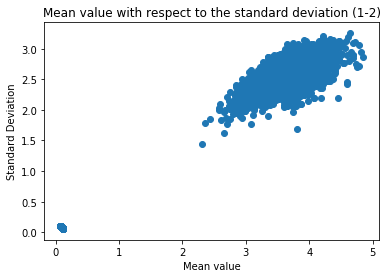

In [41]:
plt.scatter(kps12_mean, kps12_std)
plt.title('Mean value with respect to the standard deviation (1-2)')
plt.xlabel('Mean value')
plt.ylabel('Standard Deviation')
plt.savefig('Stats 1-2.png')

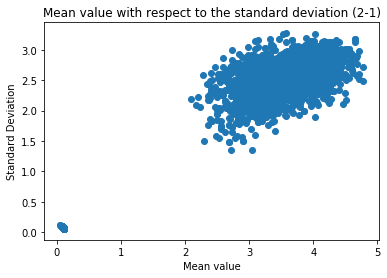

In [42]:
plt.scatter(kps21_mean, kps21_std)
plt.title('Mean value with respect to the standard deviation (2-1)')
plt.xlabel('Mean value')
plt.ylabel('Standard Deviation')
plt.savefig('Stats 2-1.png')

### Photogrammetry keypoint study

In [6]:
photogrammetryDir = 'Photogrammetry/'
#kaze = cv2.KAZE_create()
#surf = cv2.xfeatures2d.SURF_create()
surf = cv2.xfeatures2d.SURF_create()

for root, dirs, files in os.walk(photogrammetryDir):
    for file in files:
        print("Starting file: ", file)
        timeStart = time()
        filePath = os.path.join(root, file)
        image = cv2.imread(filePath, cv2.IMREAD_UNCHANGED)
        print(image.shape)
        (kps, dscs) = surf.detectAndCompute(image, None)
        #kps = kaze.detect(image)
        print(len(kps))
        print(ok)
        

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'